In [1]:
import os, shutil

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"):

    data_nomlari = ["salaries", "exams", "college", "cars_detection", "car_brands", "mall", "customers", "humanitarian",
                    "apple_disease", "insects", "cars", "crop", "dog_breeds", "rice_leaf_disease", "lentils", "brain", "flood",
                    "fruits", "aeroscapes", "cardiac", "vehicles", "cloud", "skin_lesion", "comments", "3d_data", "50_car_brands"]

    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"

    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
    elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    elif data_nomi == "cloud": url = "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset"
    elif data_nomi == "insects": url = "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset"
    elif data_nomi == "cars_detection": url = "kaggle datasets download -d killa92/car-detect-dataset"
    elif data_nomi == "skin_lesion": url = "kaggle datasets download -d killa92/skin-lesion-image-ham-classification"
    elif data_nomi == "crop": url = "kaggle datasets download -d killa92/crop-disease-image-classification-dataset"
    elif data_nomi == "comments": url = "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset"
    elif data_nomi == "car_brands": url = "kaggle datasets download mohamedaziz15/cars-brands-in-egypt"
    elif data_nomi == "3d_data": url = "kaggle datasets download glxslzt/3cla-adni"
    elif data_nomi == "50_car_brands": url = "kaggle datasets download yamaerenay/100-images-of-top-50-car-brands"
    elif data_nomi == "dog_breeds": url = "kaggle datasets download yxshee/dogs-dataset"
    elif data_nomi == "flood": url = "kaggle datasets download killa92/flood-image-segmentation"

    # Dataset yuklab olinganligini tekshirish
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # Agar dataset yuklab olinmagan bo'lsa:
    else:
        # dataset nomini aniqlash
        ds_nomi = url.split("/")[-1]
        # data saqlanadigan yo'lakni belgilash
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Datasetni belgilangan yo'lakka yuklab olish
        os.system(f"{url} -p {full_path}")
        # Arxivdan chiqarib olish
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        # Original arxiv faylni o'chirib tashlash
        os.remove(f"{full_path}/{ds_nomi}.zip")
        # Yuklab olingan datasetning nomini o'zgartirish
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")

# Funktsiyadan foydalanish misoli
data_yuklab_olish(saqlash_uchun_papka = "apple_disease_dataset", data_nomi = "apple_disease")
data_path = "apple_disease_dataset/apple_disease"

Dataset yuklab olingan. apple_disease_dataset/apple_disease papkasini ni tekshiring.


In [2]:
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torch

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, data_path, transformations = None):
        super().__init__()
        self.im_paths = []
        self.gt_paths = []
        self.get_im_mask(data_path)
        # print(len(self.im_paths), len(self.gt_paths), sep="\n")
        # self.im_paths = glob(f"{data_path}/*/images/*jpg")
        # self.gt_paths = [imp.replace("images", "labels").replace("jpg", "png") for imp in self.im_paths]
        self.transformations = transformations
    def get_im_mask(self, data_path):
        root = glob(f"{data_path}/*/images/*jpg")
        for im in root:
            gt = im.replace("images", "labels").replace("jpg", "png")
            if os.path.isfile(im) and os.path.isfile(gt):
                self.im_paths.append(im)
                self.gt_paths.append(gt)


    def read_im(self, im_path, gt_path):
        return np.array(Image.open(im_path).convert("RGB")), np.array(Image.open(gt_path).convert("L"))

    def apply_transformations(self, im, mask):
        t = self.transformations(image = im, mask = mask)
        return t["image"], t["mask"]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        im, mask = self.read_im(self.im_paths[idx], self.gt_paths[idx])
        if self.transformations:
            im, mask = self.apply_transformations(im = im, mask = mask)
        return im, (mask/255).int()



In [4]:
def get_dls(root, transformations, bs, n_cls, split = [0.9, 0.05, 0.05], ns = 2):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    ds = CustomSegmentationDataset(data_path = root, transformations = transformations)

    total_len = len(ds)
    tr_len  = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - tr_len - val_len

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} images in the train set")
    print(f"There are {len(val_ds)}  images in the validation set")
    print(f"There are {len(test_ds)} images in the test set\n")

    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, test_dl, n_cls

root = data_path
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True)], is_check_shapes = False)
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, n_cls = 2, bs = 32)


There are 10167 images in the train set
There are 564  images in the validation set
There are 566 images in the test set



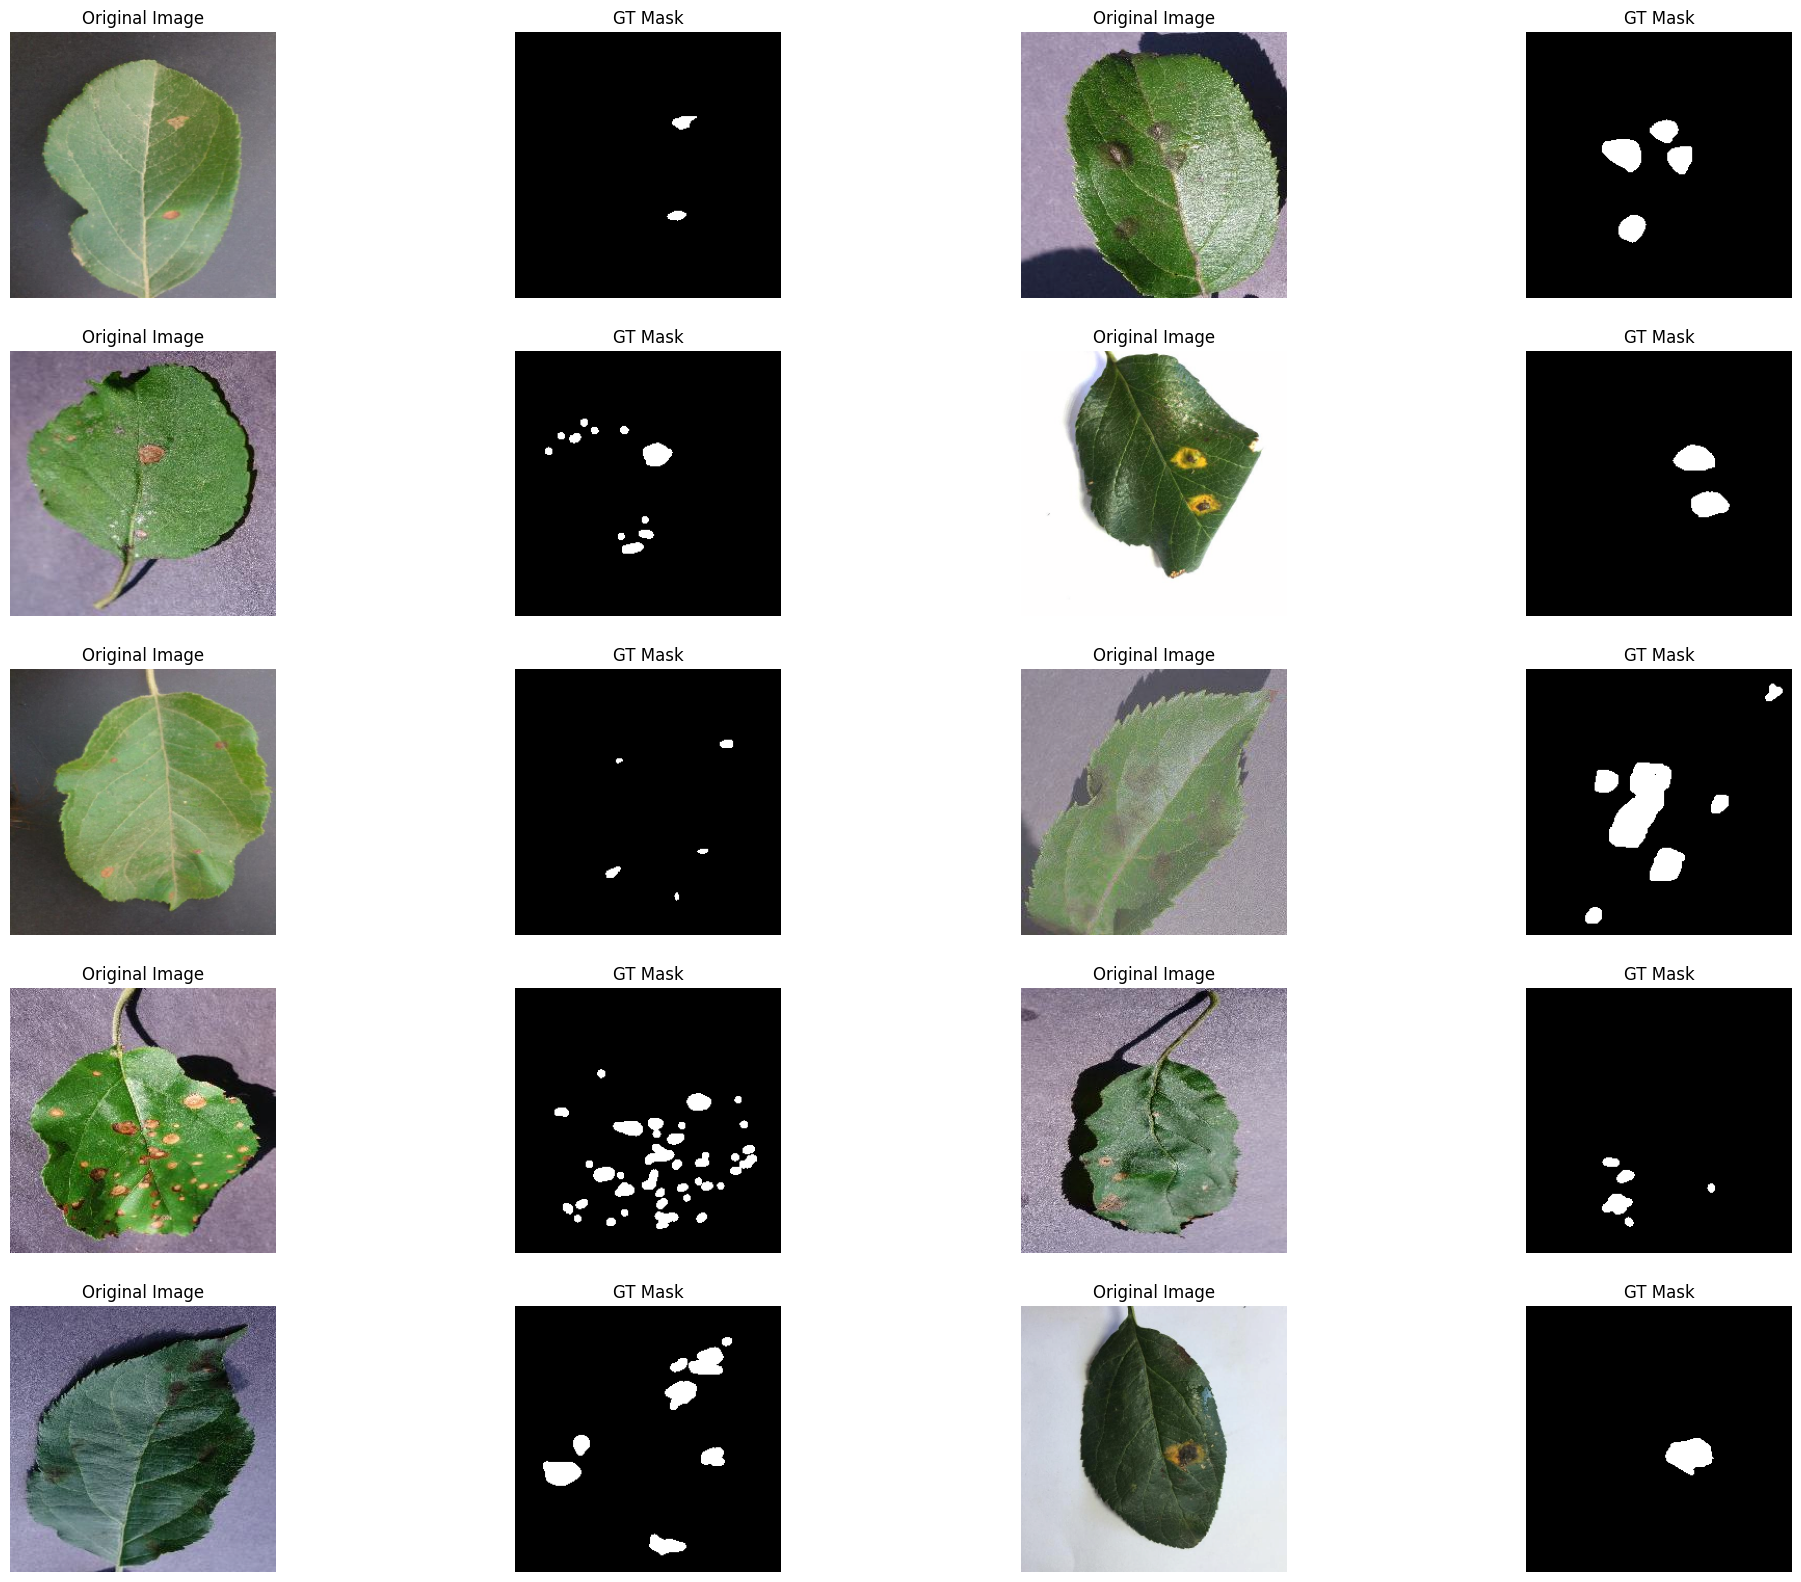

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as tfs

class DataVisualizer:
    def __init__(self, mean, std):
        """
        Initialize the DataVisualizer with mean and standard deviation for normalization.
        Args:
            mean (list): Mean values for each channel (RGB).
            std (list): Standard deviation values for each channel (RGB).
        """
        self.mean = mean
        self.std = std
        self.inv_transform = self._get_inverse_transform()

    def _get_inverse_transform(self):
        """Create an inverse transformation to revert normalization."""
        return tfs.Compose([
            tfs.Normalize(mean=[0., 0., 0.], std=[1 / s for s in self.std]),
            tfs.Normalize(mean=[-m for m in self.mean], std=[1., 1., 1.])
        ])

    def tensor_to_numpy(self, tensor):
        """
        Convert a tensor to a NumPy array, optionally reversing normalization.
        Args:
            tensor (torch.Tensor): The input tensor (C, H, W).
        Returns:
            np.ndarray: The corresponding NumPy array (H, W, C) or (H, W).
        """
        is_rgb = len(tensor) == 3
        if is_rgb:
            tensor = self.inv_transform(tensor)
            np_array = (tensor * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
        else:
            np_array = (tensor * 255).detach().cpu().numpy().astype(np.uint8)
        return np_array

    def _plot(self, rows, cols, count, image, is_gt=False, title="Original Image"):
        """
        Plot a single image or ground truth mask.
        Args:
            rows (int): Number of rows in the figure.
            cols (int): Number of columns in the figure.
            count (int): Current subplot index.
            image (torch.Tensor): The image tensor to plot.
            is_gt (bool): Whether the image is a ground truth mask.
            title (str): Title of the subplot.
        Returns:
            int: Updated subplot index.
        """
        plt.subplot(rows, cols, count)
        plt.imshow(self.tensor_to_numpy(image.squeeze(0).float()) if is_gt else self.tensor_to_numpy(image.squeeze(0)), cmap = "gray")
        plt.axis("off")
        plt.title(title)
        return count + 1

    def visualize_dataset(self, dataset, num_images):
        """
        Visualize random samples from a dataset with images and their corresponding masks.
        Args:
            dataset (Dataset): The dataset to visualize.
            num_images (int): Number of image-mask pairs to visualize.
        """
        plt.figure(figsize=(25, 20))
        rows = num_images // 4
        cols = num_images // rows
        count = 1
        indices = [random.randint(0, len(dataset) - 1) for _ in range(num_images)]

        for index in indices:
            if count > num_images:
                break
            image, mask = dataset[index]
            # Plot the original image
            count = self._plot(rows, cols, count, image)
            # Plot the ground truth mask
            count = self._plot(rows, cols, count, mask, is_gt=True, title="GT Mask")

visualizer = DataVisualizer(mean=mean, std=std)
visualizer.visualize_dataset(tr_dl.dataset, num_images=20)

In [6]:
for idx, batch in enumerate(test_dl):
    if idx == 1:
      break
    im, mask = batch



In [7]:
im.shape

torch.Size([1, 3, 256, 256])

In [8]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [9]:
model = smp.DeepLabV3Plus(classes = 2)
model.eval()
pred_raw = model(im)
pred = torch.argmax(pred_raw, dim = 1)

In [10]:
from torchvision import transforms
from PIL import Image

to_pil = transforms.ToPILImage()



In [11]:
def PA(pred, mask):
  teng = torch.eq(pred, mask)
  return float(teng.sum()) / float(teng.numel())

def MioU(pred, mask, n_cls, eps = 1e-10):
  with torch.no_grad():
    pred = pred.contiguous().view(-1)
    mask = mask.contiguous().view(-1)
    iou_per_class = []
    for clas in range(0, n_cls):
      match_pred = pred == clas
      match_mask = mask == clas
      if match_mask.long().sum().item() == 0: continue
      else:
        intersection = torch.logical_and(match_pred, match_mask)
        union = torch.logical_or(match_pred, match_mask)
        iou = (torch.sum(intersection).item()+1e-10) / (torch.sum(union).item()+eps)
        iou_per_class.append(iou)
  return np.mean(iou_per_class)

def loss(pred, mask):
  loss = torch.nn.CrossEntropyLoss()
  return loss(pred, mask)

def opt(model, lr = 1e-3):
  return torch.optim.Adam(model.parameters(), lr = lr)





In [12]:
from tqdm import tqdm
import os
class Train_validation():
  def __init__(self, model, tr_dl, vl_dl, loss, opt, pa, miou, lr = 1e-3, threshold = 0.003, early_stopping = 5):
    self.model = model
    self.tr_dl = tr_dl
    self.vl_dl = vl_dl
    self.loss = loss
    self.opt = opt(model)
    self.pa = pa
    self.miou = miou
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.lr = lr
    self.threshold = threshold
    self.early_stopping = early_stopping

  def train(self, epoch, save_root):
    os.makedirs(save_root, exist_ok = True)
    self.model.train().to(self.device)
    tr_loss, tr_pa, tr_iou = [], [], []
    vl_loss, vl_pa, vl_iou = [], [], []
    best_loss, not_improve = np.inf, 0
    for e in range(epoch):
      print(f"Epoch {e+1}/{epoch}")
      t_loss, t_pa, t_iou = 0, 0, 0
      v_loss, v_pa, v_iou = 0, 0, 0
      for batch in tqdm(self.tr_dl, desc=f"Training..."):
        im, mask = batch
        im, mask = im.to(self.device), mask.to(self.device)

        pred_raw = self.model(im)
        pred = torch.argmax(pred_raw, dim = 1)
        loss_value = self.loss(pred_raw, mask.long())

        self.opt.zero_grad()
        loss_value.backward()
        self.opt.step()

        t_loss += loss_value.item()
        t_pa += self.pa(pred, mask)
        t_iou += self.miou(pred, mask, n_cls)

      tr_loss.append(t_loss/len(self.tr_dl))
      tr_pa.append(t_pa/len(self.tr_dl))
      tr_iou.append(t_iou/len(self.tr_dl))
      for batch in tqdm(self.vl_dl, desc=f"Validating..."):
        self.model.eval().to(self.device)
        im, mask = batch
        im, mask = im.to(self.device), mask.to(self.device)

        pred_raw = self.model(im)
        pred = torch.argmax(pred_raw, dim = 1)
        loss_value = self.loss(pred_raw, mask.long())

        v_loss += loss_value.item()
        v_pa += self.pa(pred, mask)
        v_iou += self.miou(pred, mask, n_cls)
        f_loss =v_loss/len(self.vl_dl)
      vl_loss.append(f_loss)
      vl_pa.append(v_pa/len(self.vl_dl))
      vl_iou.append(v_iou/len(self.vl_dl))
      print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
      print(f"Train Loss: {tr_loss[e]:.3f} | Train PA: {tr_pa[e]:.3f} | Train IoU: {tr_iou[e]:.3f}")
      print(f"Val Loss:   {vl_loss[e]:.3f} | Val PA:   {vl_pa[e]:.3f} | Val IoU:   {vl_iou[e]:.3f}")
      print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
      if best_loss>(f_loss+self.threshold):
          best_loss = f_loss
          torch.save(self.model, f"{save_root}/best_model.pth")
          print(f"Validation loss decreased from {vl_loss[e-1]:.3f} to {vl_loss[e]:.3f}")
          print(f"Model saved to {save_root}/best_model.pth")
          not_improve = 0
      else:
          not_improve += 1
          print(f"No improvement for {not_improve} epoch(s)")
          if not_improve == self.early_stopping:
              print(f"Early stopping at epoch {e+1}")

              break
    return  {"tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou, "vl_loss": vl_loss, "vl_pa": vl_pa, "vl_iou": vl_iou}


In [13]:
do_train = Train_validation(model = model, tr_dl = tr_dl, vl_dl = val_dl, loss = loss, opt = opt, pa = PA, miou = MioU, lr = 1e-3)

In [14]:
stats = do_train.train(epoch = 100, save_root = "save_root")

Epoch 1/100


Validating...: 100%|██████████| 18/18 [00:03<00:00,  5.56it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train Loss: 0.044 | Train PA: 0.986 | Train IoU: 0.805
Val Loss:   0.027 | Val PA:   0.989 | Val IoU:   0.838
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss decreased from 0.027 to 0.027
Model saved to save_root/best_model.pth
Epoch 2/100


Validating...: 100%|██████████| 18/18 [00:03<00:00,  5.78it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train Loss: 0.302 | Train PA: 0.977 | Train IoU: 0.690
Val Loss:   0.051 | Val PA:   0.983 | Val IoU:   0.733
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No improvement for 1 epoch(s)
Epoch 3/100


Validating...: 100%|██████████| 18/18 [00:03<00:00,  5.75it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train Loss: 0.044 | Train PA: 0.984 | Train IoU: 0.761
Val Loss:   0.043 | Val PA:   0.984 | Val IoU:   0.782
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No improvement for 2 epoch(s)
Epoch 4/100


Validating...: 100%|██████████| 18/18 [00:03<00:00,  5.05it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train Loss: 0.039 | Train PA: 0.986 | Train IoU: 0.784
Val Loss:   0.038 | Val PA:   0.985 | Val IoU:   0.799
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No improvement for 3 epoch(s)
Epoch 5/100


Validating...: 100%|██████████| 18/18 [00:03<00:00,  5.25it/s]



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train Loss: 0.035 | Train PA: 0.987 | Train IoU: 0.802
Val Loss:   0.034 | Val PA:   0.987 | Val IoU:   0.802
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No improvement for 4 epoch(s)
Epoch 6/100


Validating...: 100%|██████████| 18/18 [00:03<00:00,  5.70it/s]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train Loss: 0.032 | Train PA: 0.988 | Train IoU: 0.813
Val Loss:   0.035 | Val PA:   0.986 | Val IoU:   0.813
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

No improvement for 5 epoch(s)
Early stopping at epoch 6


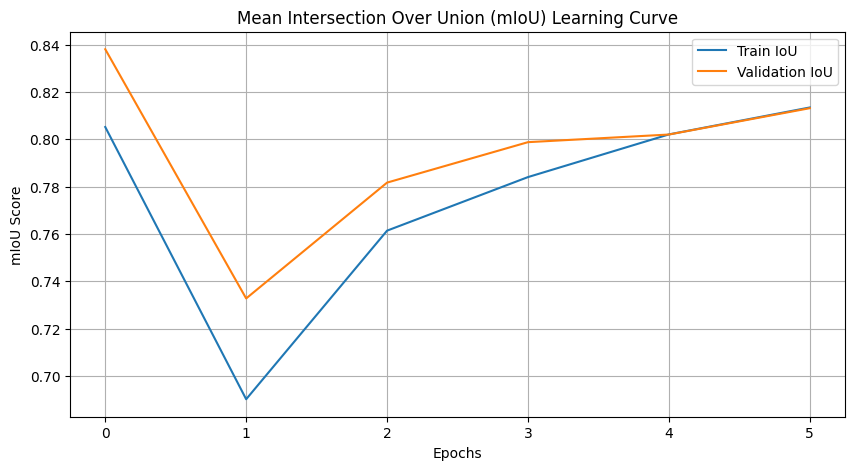

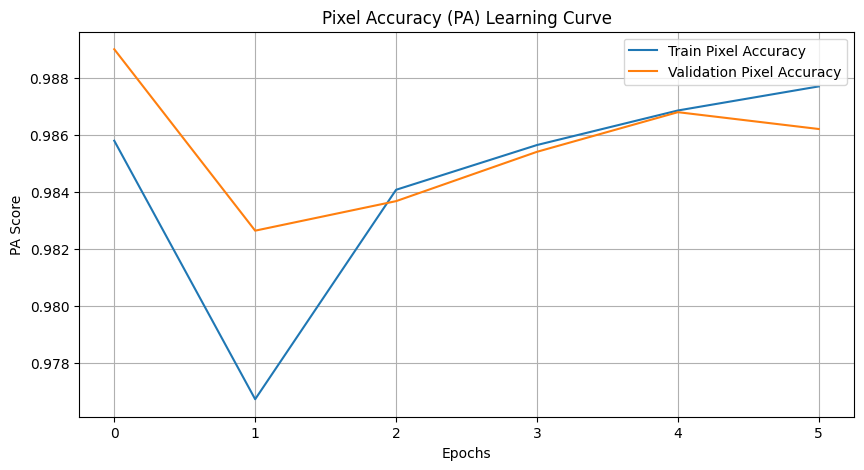

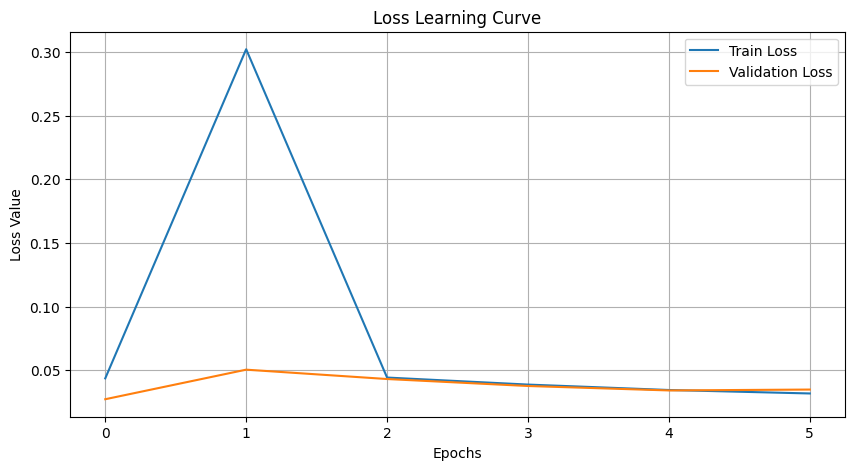

In [15]:
class Plot:
    def __init__(self, history):
        """
        Initialize the Plot class with the training and validation history.

        Args:
            history (dict): Dictionary containing training and validation metrics.
        """
        self.history = history
        self.plot_all()

    def plot_metric(self, metric1, metric2, label1, label2, title, ylabel):
        """
        Plot a comparison of two metrics over epochs.

        Args:
            metric1 (str): Key for the first metric in the history dictionary.
            metric2 (str): Key for the second metric in the history dictionary.
            label1 (str): Label for the first metric in the plot.
            label2 (str): Label for the second metric in the plot.
            title (str): Title of the plot.
            ylabel (str): Y-axis label.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.history[metric1], label=label1)
        plt.plot(self.history[metric2], label=label2)
        plt.title(title)
        plt.xlabel("Epochs")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_all(self):
        """
        Plot learning curves for IoU, PA, and Loss metrics.
        """
        self.plot_metric(
            metric1="tr_iou", metric2="vl_iou",
            label1="Train IoU", label2="Validation IoU",
            title="Mean Intersection Over Union (mIoU) Learning Curve",
            ylabel="mIoU Score"
        )
        self.plot_metric(
            metric1="tr_pa", metric2="vl_pa",
            label1="Train Pixel Accuracy", label2="Validation Pixel Accuracy",
            title="Pixel Accuracy (PA) Learning Curve",
            ylabel="PA Score"
        )
        self.plot_metric(
            metric1="tr_loss", metric2="vl_loss",
            label1="Train Loss", label2="Validation Loss",
            title="Loss Learning Curve",
            ylabel="Loss Value"
        )

Plot(stats)

<ipython-input-16-1bcb6bc77938>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path, map_location=device)


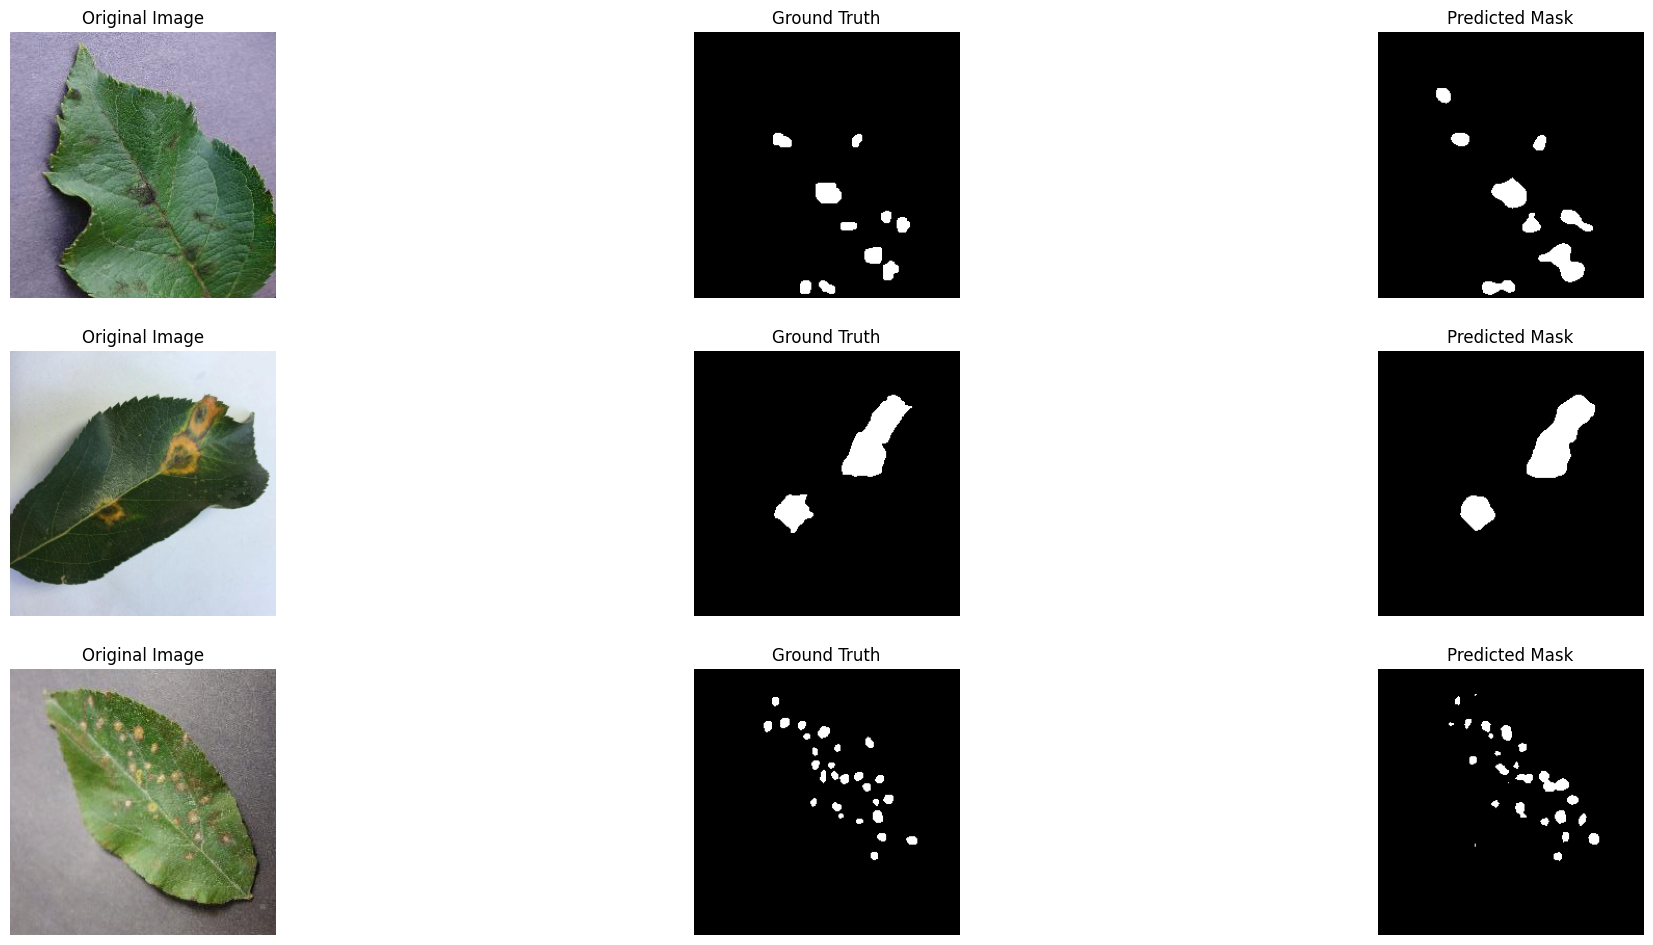

In [16]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as tfs
import numpy as np


class Inference:
    def __init__(self, model_path, device):
        """
        Initialize the Inference class.

        Args:
            model_path (str): Path to the saved model.
            device (str): Device to run the model on ("cpu" or "cuda").
        """
        self.device = device
        self.model = torch.load(model_path, map_location=device)
        self.model.to(device)
        self.model.eval()

    def tn_2_np(self, t):
        """
        Convert a tensor to a numpy array for visualization.

        Args:
            t (torch.Tensor): Input tensor.

        Returns:
            np.ndarray: Converted numpy array.
        """
        invTrans = tfs.Compose([
            tfs.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
            tfs.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
        ]) # inverse transformation (denormalization)
        rgb = True if len(t.shape) == 3 else False
        return (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8) if rgb else (t * 255).detach().cpu().numpy().astype(np.uint8)

    def plot(self, rows, cols, count, im, gt=None, title="Original Image"):
        """
        Plot an image, ground truth, or predicted mask.

        Args:
            rows (int): Number of rows in the plot.
            cols (int): Number of columns in the plot.
            count (int): Current subplot index.
            im (torch.Tensor): Image to plot.
            gt (bool, optional): Whether this is ground truth. Defaults to None.
            title (str, optional): Title of the plot. Defaults to "Original Image".

        Returns:
            int: Updated subplot index.
        """
        plt.subplot(rows, cols, count)
        plt.imshow(self.tn_2_np(im.squeeze(0).float()), cmap = "gray") if gt else plt.imshow(self.tn_2_np(im.squeeze(0)), cmap = "gray")
        plt.axis("off")
        plt.title(title)
        return count + 1

    def run(self, dl, n_ims=15, cols = 3):
        """
        Run inference and visualize results.

        Args:
            dl (DataLoader): DataLoader containing test data.
            n_ims (int, optional): Number of images to visualize. Defaults to 15.
        """

        rows = n_ims // cols
        count = 1
        ims, gts, preds = [], [], []

        # Perform inference
        for idx, data in enumerate(dl):
            im, gt = data

            with torch.no_grad():
                pred = torch.argmax(self.model(im.to(self.device)), dim=1) # (bs, chs, im_h, im_w) -> (bs, im_h, im_w) ->

            ims.append(im)
            gts.append(gt)
            preds.append(pred)

        # Visualize results
        plt.figure(figsize=(25, 20))
        for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
            if idx == cols:
                break

            # Plot original image
            count = self.plot(rows, cols, count, im)

            # Plot ground truth
            count = self.plot(rows, cols, count, im=gt.squeeze(0), gt=True, title="Ground Truth")

            # Plot predicted mask
            count = self.plot(rows, cols, count, im=pred, title="Predicted Mask")

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "save_root/best_model.pth"
inference_runner = Inference(model_path=model_path, device=device)
inference_runner.run(test_dl, n_ims=15)